##PCA로 차원 축소 후 클러스터링

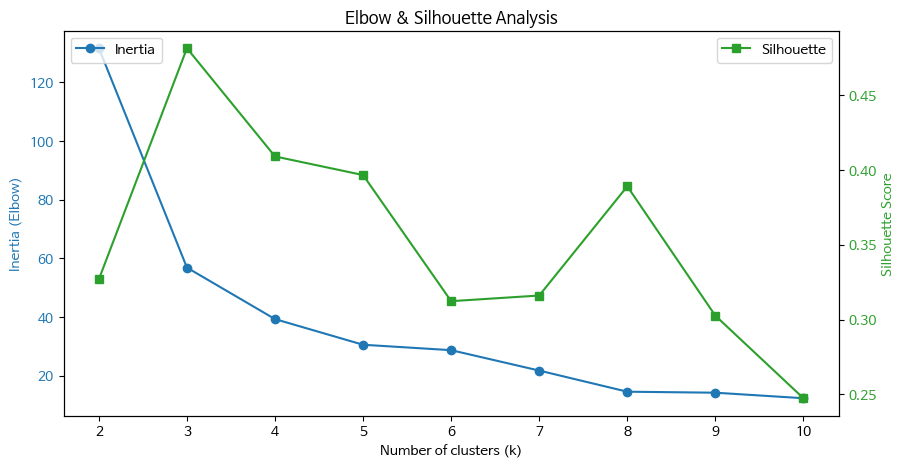

In [ ]:
# 자치구명 정리 함수
def clean_gu(name):
    return re.sub(r'[^가-힣]', '', str(name)).replace('서울특별시', '').strip()

# 데이터 불러오기
df = pd.read_excel("/content/drive/MyDrive/코랩/데이터마이닝/팀플/전처리데이터_노인인구포함.xlsx", sheet_name="Sheet1")
df["자치구"] = df["자치구"].apply(clean_gu)

# 1인당으로 환산할 변수 목록
per_capita_vars = [
    "독거노인 합계", "기초수급자 합계", "저소득노인 합계",
    "노인의료복지시설 수", "재가노인복지시설 수", "복지관 수",
    "복지관종사자 수", "노인교실 수", "정류장수"
]

for var in per_capita_vars:
    df[f"1인당 {var}"] = df[var] / df["노인인구 수"]
df = df.drop(columns=per_capita_vars)

# 클러스터링 대상 변수
features_for_clustering = df.columns.drop("자치구")
X_filtered = df[features_for_clustering]
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# PCA로 2D로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_filtered)

# Elbow & Silhouette 계산
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color)
ax1.plot(K_range, inertias, marker='o', color=color, label="Inertia")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='s', color=color, label="Silhouette")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right")

plt.title("Elbow & Silhouette Analysis")
plt.show()


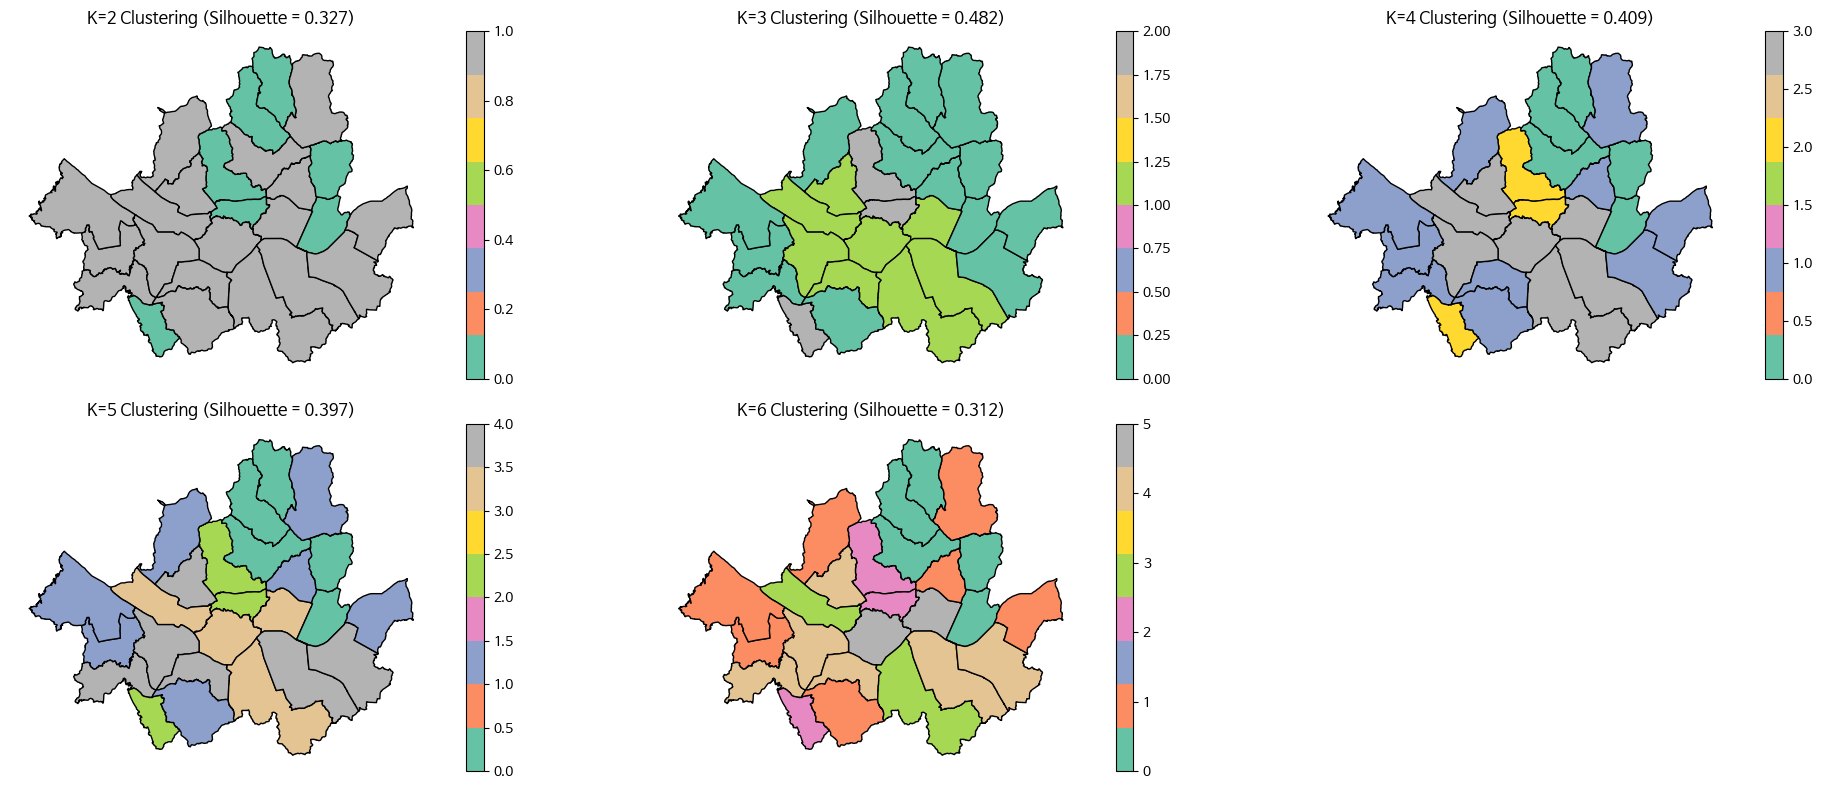

📊 실루엣 계수 (PCA 2D 축소 후):
K=2: 0.327
K=3: 0.4816
K=4: 0.4092
K=5: 0.3967
K=6: 0.3123


In [ ]:
# 클러스터링 & 지도 시각화
silhouette_scores_pca = {}
cluster_summaries_pca = {}

plt.figure(figsize=(20, 8))

for idx, k in enumerate(range(2, 7)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df[f"클러스터_PCA_{k}"] = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, df[f"클러스터_PCA_{k}"])
    silhouette_scores_pca[k] = round(score, 4)

    summary = df.groupby(f"클러스터_PCA_{k}")[features_for_clustering].mean()
    cluster_summaries_pca[k] = summary

    # 지도 시각화
    shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
    gdf = gpd.read_file(shp_path)
    gdf = gdf.rename(columns={"SGG_NM": "자치구"})
    gdf["자치구"] = gdf["자치구"].apply(clean_gu)
    gdf = gdf.to_crs(epsg=4326)

    merged = gdf.merge(df, on="자치구", how="left")
    plt.subplot(2, 3, idx + 1)
    merged.plot(column=f"클러스터_PCA_{k}", cmap="Set2", legend=True, edgecolor="black", ax=plt.gca())
    plt.title(f"K={k} Clustering (Silhouette = {silhouette_scores_pca[k]:.3f})", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 결과 출력
print("📊 실루엣 계수 (PCA 2D 축소 후):")
for k, score in silhouette_scores_pca.items():
    print(f"K={k}: {score}")

In [ ]:
cols_to_use = [
    '추정 노인 자살률', '경로당 수', '요양보호사 수', '평균노선수', '노인 보행 교통사고',
    '노인인구 수', '1인당 독거노인 합계', '1인당 기초수급자 합계', '1인당 저소득노인 합계',
    '1인당 노인의료복지시설 수', '1인당 재가노인복지시설 수', '1인당 복지관 수',
    '1인당 복지관종사자 수', '1인당 노인교실 수', '1인당 정류장수'
]

cluster_summary = df.groupby('클러스터_PCA_3')[cols_to_use].mean()
cluster_summary

,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
클러스터_PCA_3,,,,,,,,,,,,,,,
0,36.159707,154.071429,20437.196429,3.609024,91.500,82014.500,0.261753,0.083290,0.008039,0.000157,0.001329,0.000040,0.001304,0.000178,0.005499
1,31.100641,143.500000,12142.000000,3.554277,61.375,61933.375,0.234724,0.054872,0.005394,0.000076,0.000939,0.000065,0.001525,0.000251,0.008220
2,40.252991,61.666667,6245.666667,4.089782,67.000,33342.000,0.322079,0.081704,0.013755,0.000221,0.001096,0.000090,0.004202,0.000194,0.010109


In [ ]:
print(df[['자치구', '클러스터_PCA_3']])

     자치구  클러스터_PCA_3
0    종로구           2
1     중구           2
2    용산구           1
3    성동구           1
4    광진구           0
5   동대문구           0
6    중랑구           0
7    성북구           0
8    강북구           0
9    도봉구           0
10   노원구           0
11   은평구           0
12  서대문구           1
13   마포구           1
14   양천구           0
15   강서구           0
16   구로구           0
17   금천구           2
18  영등포구           1
19   동작구           1
20   관악구           0
21   서초구           1
22   강남구           1
23   송파구           0
24   강동구           0


In [ ]:
cluster_summary

,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
클러스터_PCA_3,,,,,,,,,,,,,,,
0,36.159707,154.071429,20437.196429,3.609024,91.500,82014.500,0.261753,0.083290,0.008039,0.000157,0.001329,0.000040,0.001304,0.000178,0.005499
1,31.100641,143.500000,12142.000000,3.554277,61.375,61933.375,0.234724,0.054872,0.005394,0.000076,0.000939,0.000065,0.001525,0.000251,0.008220
2,40.252991,61.666667,6245.666667,4.089782,67.000,33342.000,0.322079,0.081704,0.013755,0.000221,0.001096,0.000090,0.004202,0.000194,0.010109


In [ ]:
# 군집별 대표 자치구 찾기
representative_districts = {}

for cluster_num in df_cleaned['클러스터_PCA_3'].unique():
    # 해당 군집 데이터
    cluster_data = df_cleaned[df_cleaned['클러스터_PCA_3'] == cluster_num][cols_to_use]

    # 군집 중심 (평균값)
    cluster_center = cluster_data.mean().values.reshape(1, -1)

    # 각 자치구 데이터와 군집 중심 거리 계산
    indices, distances = pairwise_distances_argmin_min(cluster_data, cluster_center)

    # 대표 자치구: 중심값과 가장 가까운 자치구
    closest_gu = df_cleaned[df_cleaned['클러스터_PCA_3'] == cluster_num].iloc[indices[0]]['자치구']
    representative_districts[cluster_num] = closest_gu

print("\nCluster별 대표 자치구:")
for cluster_num, gu_name in representative_districts.items():
    print(f"Cluster {cluster_num}: {gu_name}")


Cluster별 대표 자치구:
Cluster 2: 종로구
Cluster 1: 용산구
Cluster 0: 광진구


<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]
<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]
<ipython-input-40-a241fddcbb62>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = rep_row.geometry.centroid.iloc[0]


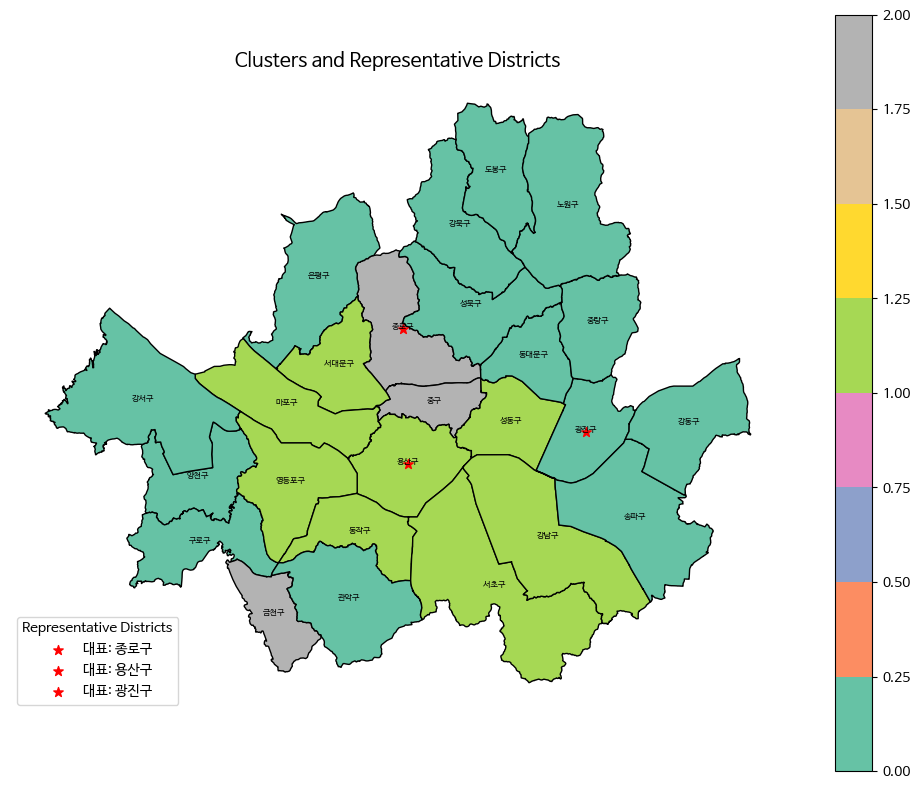

In [ ]:
shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
gdf = gpd.read_file(shp_path).rename(columns={"SGG_NM": "자치구"})
gdf["자치구"] = gdf["자치구"].apply(lambda x: x.replace("서울특별시", "").strip())
gdf = gdf.to_crs(epsg=4326)

# 군집 결과를 병합
merged = gdf.merge(df_cleaned[['자치구', '클러스터_PCA_3']], on='자치구', how='left')

# 지도 시각화
fig, ax = plt.subplots(figsize=(10, 8))
merged.plot(column='클러스터_PCA_3', cmap='Set2', legend=True, edgecolor='black', ax=ax)
ax.set_title("Clusters and Representative Districts", fontsize=14)

# 대표 자치구 위치만 강조 (별 표시)
for cluster_num, gu_name in representative_districts.items():
    rep_row = merged[merged['자치구'] == gu_name]
    centroid = rep_row.geometry.centroid.iloc[0]
    ax.scatter(centroid.x, centroid.y, color='red', s=50, marker='*', label=f'대표: {gu_name}')

# 🔹 각 자치구 이름을 **한글로** 표시
for idx, row in merged.iterrows():
    if pd.notnull(row['자치구']):
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['자치구'], ha='center', fontsize=6, color='black')

# 축 제거 및 범례 표시
ax.axis("off")
ax.legend(title='Representative Districts', loc='lower left')
plt.tight_layout()
plt.show()

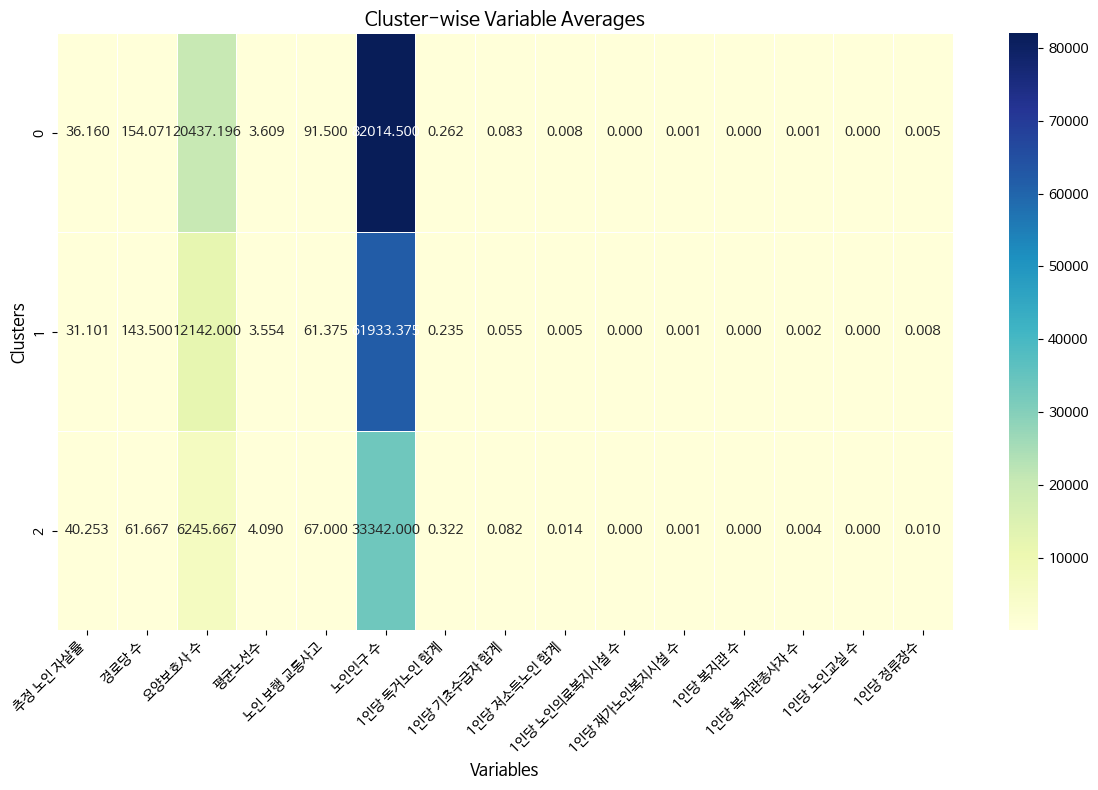

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=0.5)
plt.title('Cluster-wise Variable Averages', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

클러스터 간 차이가 큰 변수들: ['경로당 수', '요양보호사 수', '노인 보행 교통사고', '노인인구 수']


<ipython-input-42-b22c1188b788>:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


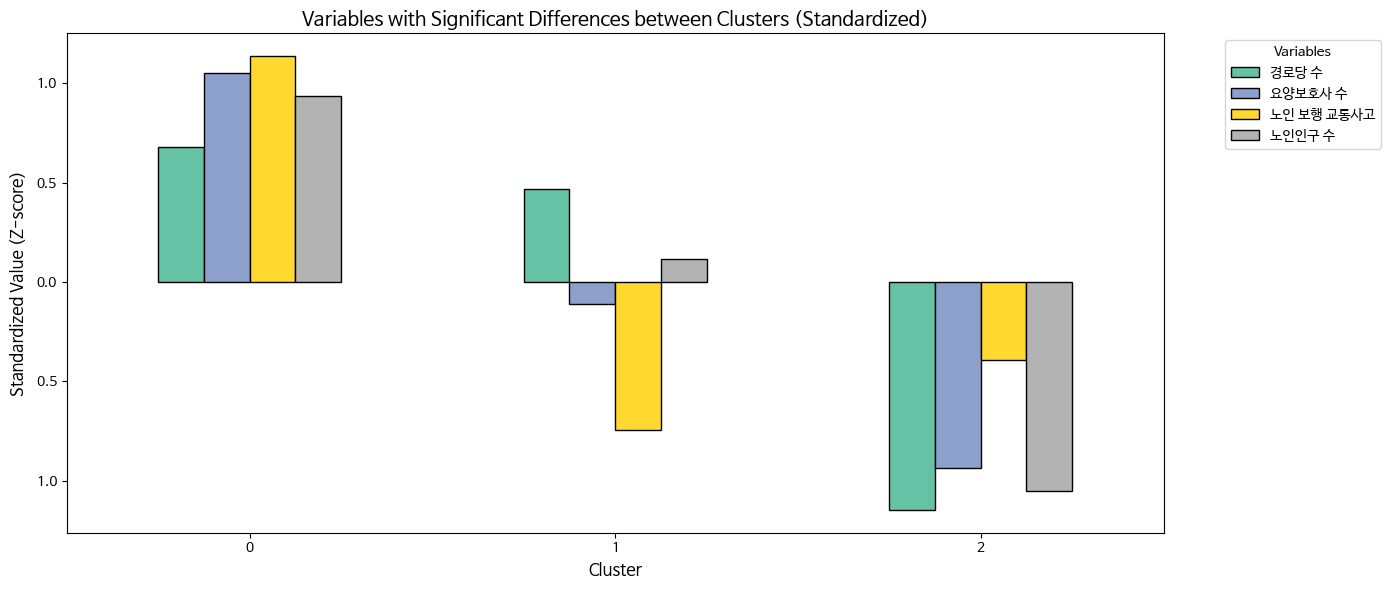

In [ ]:
diff = cluster_summary.max() - cluster_summary.min()

# 차이가 큰 변수만 선택 (예: 10 이상 차이)
important_vars = diff[diff > 10].index.tolist()
print("클러스터 간 차이가 큰 변수들:", important_vars)

# 차이가 큰 변수만 선택
cluster_summary_selected = cluster_summary[important_vars]

# Z-score로 변환 (표준화)
cluster_summary_standardized = (cluster_summary_selected - cluster_summary_selected.mean()) / cluster_summary_selected.std()

# 바 차트로 시각화
cluster_summary_standardized.plot(kind='bar', figsize=(14, 6), colormap='Set2', edgecolor='black')
plt.title('Variables with Significant Differences between Clusters (Standardized)', fontsize=14)
plt.ylabel('Standardized Value (Z-score)', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 클러스터별 우선순위 도출

In [ ]:
#  카테고리별 변수 지정
infra_vars = ['1인당 복지관 수', '1인당 노인의료복지시설 수', '1인당 재가노인복지시설 수']
service_vars = ['요양보호사 수', '1인당 복지관종사자 수']
mobility_vars = ['1인당 정류장수', '평균노선수']
vulnerable_vars = ['1인당 독거노인 합계', '추정 노인 자살률']

#  Z-score로 표준화
standardized = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

# 가중치 설정
weights = {
    'infra': 0.15,
    'service': 0.25,
    'mobility': 0.15,
    'vulnerable': 0.45
}

# 카테고리별 평균 점수 (취약계층 역방향)
infra_score = standardized[infra_vars].mean(axis=1)
service_score = standardized[service_vars].mean(axis=1)
mobility_score = standardized[mobility_vars].mean(axis=1)
vulnerable_score = -standardized[vulnerable_vars].mean(axis=1)

# 가중합으로 최종 우선순위 점수 계산
priority_score = (
    infra_score * weights['infra'] +
    service_score * weights['service'] +
    mobility_score * weights['mobility'] +
    vulnerable_score * weights['vulnerable']
)

# 결과 데이터프레임
priority_df = pd.DataFrame({
    'Priority Score': priority_score
}, index=[0, 1, 2])

# 자치구-클러스터 매핑
gu_cluster_df = pd.DataFrame({
    '자치구': ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구',
             '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구',
             '관악구', '서초구', '강남구', '송파구', '강동구'],
    '클러스터_PCA_3': [2, 2, 1, 1, 0, 0, 0, 0, 0, 0,
                    0, 0, 1, 1, 0, 0, 0, 2, 1, 1,
                    0, 1, 1, 0, 0]
})

# 클러스터별 자치구명 리스트로 정리
cluster_gu_dict = gu_cluster_df.groupby('클러스터_PCA_3')['자치구'].apply(list).to_dict()

# 우선순위 높은 순으로 정렬
priority_df_sorted = priority_df.sort_values('Priority Score', ascending=True)
priority_df_sorted['정책 도입 순위'] = range(1, len(priority_df_sorted) + 1)

# 각 순위별로 포함된 자치구 출력
print(" 클러스터별 최종 정책 도입 순위 및 자치구:")
for idx, row in priority_df_sorted.iterrows():
    cluster_id = idx
    gu_list = cluster_gu_dict.get(cluster_id, [])
    순위 = int(row['정책 도입 순위'])
    print(f"\n순위 {순위}위 (클러스터 {cluster_id}) - 정책 시급도: {row['Priority Score']:.3f}")
    print("포함된 자치구:", ', '.join(gu_list))

 클러스터별 최종 정책 도입 순위 및 자치구:

순위 1위 (클러스터 2) - 정책 시급도: -0.190
포함된 자치구: 종로구, 중구, 금천구

순위 2위 (클러스터 0) - 정책 시급도: -0.018
포함된 자치구: 광진구, 동대문구, 중랑구, 성북구, 강북구, 도봉구, 노원구, 은평구, 양천구, 강서구, 구로구, 관악구, 송파구, 강동구

순위 3위 (클러스터 1) - 정책 시급도: 0.208
포함된 자치구: 용산구, 성동구, 서대문구, 마포구, 영등포구, 동작구, 서초구, 강남구


In [ ]:
# 불필요한 클러스터링 열 제거
df_cleaned = df.drop(columns=['클러스터_PCA_2', '클러스터_PCA_4', '클러스터_PCA_5', '클러스터_PCA_6'])

# 결과 확인
print(df_cleaned.columns)

Index(['자치구', '추정 노인 자살률', '경로당 수', '요양보호사 수', '평균노선수', '노인 보행 교통사고', '노인인구 수',
       '1인당 독거노인 합계', '1인당 기초수급자 합계', '1인당 저소득노인 합계', '1인당 노인의료복지시설 수',
       '1인당 재가노인복지시설 수', '1인당 복지관 수', '1인당 복지관종사자 수', '1인당 노인교실 수', '1인당 정류장수',
       '클러스터_PCA_3'],
      dtype='object')
